# Comparative study of Geomstat & PyRiemann frameworks

We compare the 2 frameworks on differents datasets for different metrics, and plot both classification scores and computation time.

### Imports

In [7]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import seaborn as sns
from mne.decoding import CSP
from pyriemann.classification import MDM
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

import moabb
from moabb.datasets import AlexMI
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import LeftRightImagery

In [3]:
moabb.set_log_level("info")
warnings.filterwarnings("ignore")


### Test Samples (Datasets - subjects)

As a sample dataset, we use:
- moabb.datasets.AlexMI



This Dataset contains EEG recordings from 8 subjects, performing 2 task of motor imagination (right hand, feet or rest). Data have been recorded at 512Hz with 16 wet electrodes (Fpz, F7, F3, Fz, F4, F8, T7, C3, Cz, C4, T8, P7, P3, Pz, P4, P8) with a g.tec g.USBamp EEG amplifier.

File are provided in MNE raw file format. A stimulation channel encoding the timing of the motor imagination. The start of a trial is encoded as 1, then the actual start of the motor imagination is encoded with 2 for imagination of a right hand movement, 3 for imagination of both feet movement and 4 with a rest trial.

The duration of each trial is 3 second. There is 20 trial of each class.


In [11]:
dataset = AlexMI()
vars(dataset)

{'subject_list': [1, 2, 3, 4, 5, 6, 7, 8],
 'n_sessions': 1,
 'event_id': {'right_hand': 2, 'feet': 3, 'rest': 4},
 'code': 'Alexandre Motor Imagery',
 'interval': [0, 3],
 'paradigm': 'imagery',
 'doi': None,
 'unit_factor': 1000000.0}

In [16]:
sessions = dataset.get_data(subjects=[1])
subject = 1
session_name = "session_0"
run_name = "run_0"
raw = sessions[subject][session_name][run_name]

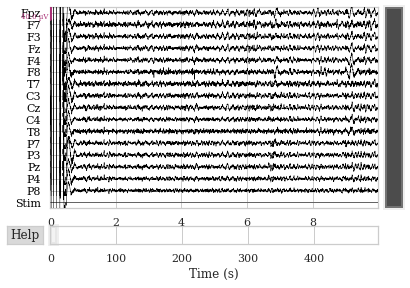

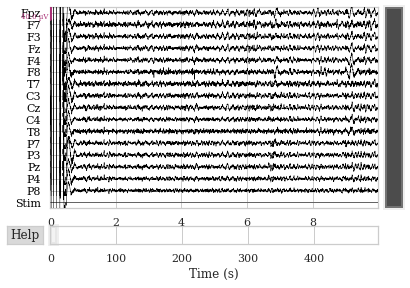

In [75]:
raw.plot()

### Datasets preprocessing

In [82]:
def f(d):
    res = np.zeros(d.shape)
    res[:, 1:] = d[:, 0:-1]
    return res

In [84]:
data = data.squeeze()
def find_start_alexmi(data):
    """Find start of trials for ALexMI dataset.
    """
    assert len(data.shape)==2
    return np.argwhere((data[-1, :]==1) & (f(data)[-1, :]==0))

In [67]:
data = raw.get_data()
(Ne, Ns) = data.shape
data = data.reshape(1, Ne, Ns) # introduce Number of trials dimension
m = Covariances().fit_transform(data)

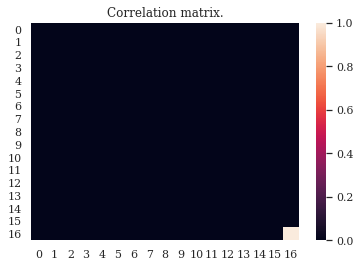

In [68]:
sns.heatmap(np.squeeze(m), vmin=0, vmax=1)

plt.title("Correlation matrix.")
plt.show()

### Creating Pipeline

In [ ]:
pipelines = {}
pipelines["AM+LDA"] = make_pipeline(LogVariance(), LDA())
parameters = {"C": np.logspace(-2, 2, 10)}
clf = GridSearchCV(SVC(kernel="linear"), parameters)
pipe = make_pipeline(LogVariance(), clf)

pipelines["AM+SVM"] = pipe

### Evaluation

In [ ]:
evaluation = CrossSessionEvaluation(
    paradigm=paradigm, datasets=datasets, suffix="examples", overwrite=False
)
results = evaluation.process(pipelines)

In [ ]:
evaluation = WithinSessionEvaluation(
    paradigm=paradigm,
    datasets=[dataset],
    overwrite=True,
    hdf5_path=None,
)

In [ ]:
results = evaluation.process(pipelines)
results.to_csv("./results_part2-1.csv")
results = pd.read_csv("./results_part2-1.csv")

### Plotting results

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))
results["subj"] = results["subject"].apply(str)
sns.barplot(
    x="score", y="subj", hue="session", data=results, orient="h", palette="viridis", ax=ax
)
fig.show()

In [ ]:
results["subj"] = [str(resi).zfill(2) for resi in results["subject"]]
g = sns.catplot(
    kind="bar",
    x="score",
    y="subj",
    col="dataset",
    data=results,
    orient="h",
    palette="viridis",
)
plt.show()